In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import scipy 
import torchvision
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision.transforms as transforms
import random
import torch
from scipy.ndimage import zoom

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np




/local/home/abizeul/miniconda3/envs/reconstruction/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/local/home/abizeul/miniconda3/envs/reconstruction/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# setting seeds
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 

In [3]:
# downloading datasets
# For torchvision datasets
transform = transforms.Compose([transforms.ToTensor()])

# Download FashionMNIST
fashionmnist_trainset = torchvision.datasets.FashionMNIST(root='/local/home/abizeul/data', train=True, download=True, transform=transform)

# Download CIFAR10
cifar10_trainset = torchvision.datasets.CIFAR10(root='/local/home/abizeul/data', train=True, download=True, transform=transform)

# Download CIFAR100
cifar100_trainset = torchvision.datasets.CIFAR100(root='/local/home/abizeul/data', train=True, download=True, transform=transform)

# Download MNIST
mnist_trainset = torchvision.datasets.MNIST(root='/local/home/abizeul/data', train=True, download=True, transform=transform)

# For tensorflow_datasets datasets
datasets_to_download = [ 'svhn_cropped']

for dataset in datasets_to_download:
    svhn_trainset = tfds.load(name=dataset, split=['train'], data_dir='/local/home/abizeul/data', download=True)

Files already downloaded and verified
Files already downloaded and verified


2024-06-29 23:27:45.389010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 23:27:45.389809: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 23:27:45.422584: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 23:27:45.545924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 23:27:46.077554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [4]:
# functions
def create_dataloader(dataset, nsamples=100, batch_size=1):
    indices = np.random.choice(len(dataset), size=nsamples, replace=False)
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    return dataloader

def tfds_to_torch(tfds_dataset):
    data = []
    for example in tfds_dataset:
        data.append((example["image"].numpy(), example["label"].numpy()))
    images, labels = zip(*data)
    images = np.array(images)
    labels = np.array(labels)
    images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0 if images.ndim == 4 else torch.tensor(images).unsqueeze(1).float() / 255.0
    labels = torch.tensor(labels).long()
    return TensorDataset(images, labels)

def fft(image):
    f_image = np.fft.fft2(image)
    fourier_amplitudes = np.abs(f_image) #**2
    fourier_amplitudes = np.fft.fftshift(fourier_amplitudes,[0,1])
    return fourier_amplitudes

def fft_planes(image):
    fourier_amplitudes = fft(image)
    threshold=int(image.shape[0]/2)
    quarter_fa = fourier_amplitudes[threshold:,threshold:]
    plane_0 = quarter_fa[:,0]
    plane_45 = np.diagonal(quarter_fa)
    plane_90 = quarter_fa[0,:]

    return plane_0, plane_45, plane_90

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def torch2np_image(torch_image):
    torch_image = torch.stack([(torch_image[i] / 2 + 0.5).clamp(0, 1) if True else torch_image[i] for i in range(torch_image.shape[0])])
    np_image = torch_image.cpu().permute(0, 2, 3, 1).float().numpy()
    return np_image

In [5]:
# lets create datasets and dataloaders of 100 images 
fashionmnist_loader = create_dataloader(fashionmnist_trainset)
cifar10_loader = create_dataloader(cifar10_trainset)
cifar100_loader = create_dataloader(cifar100_trainset)
mnist_loader = create_dataloader(mnist_trainset)
svhn_loader = create_dataloader(tfds_to_torch(svhn_trainset[0]))


2024-06-21 09:48:02.341279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# computing the fft before masking 
dataloaders = {
    'FashionMNIST': fashionmnist_loader,
    'CIFAR10': cifar10_loader,
    'CIFAR100': cifar100_loader,
    'MNIST': mnist_loader,
    'SVHN': svhn_loader
}

# Example: Iterate through the FashionMNIST dataloader
for k in list(dataloaders.keys()):
    for images, labels in dataloaders[k]:
        print(k,images.shape, labels.shape)
        break

NameError: name 'fashionmnist_loader' is not defined

FashionMNIST


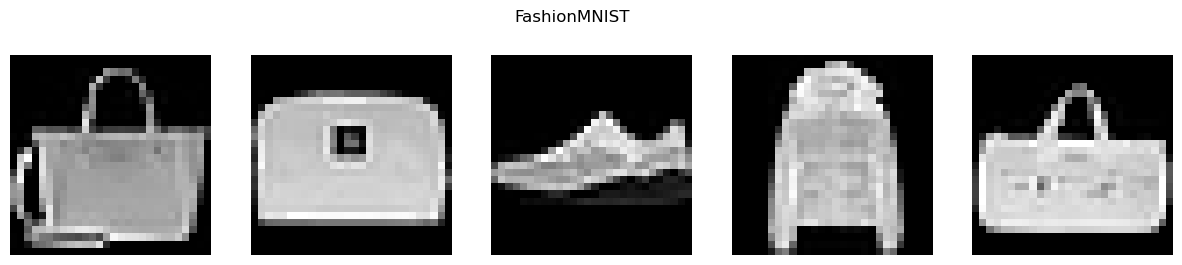

CIFAR10


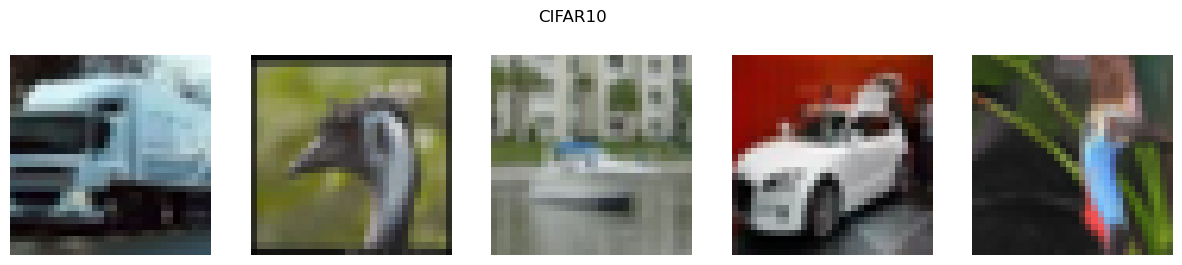

CIFAR100


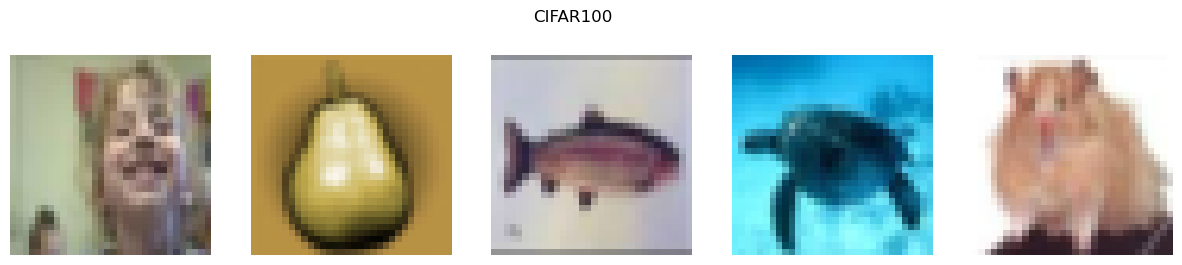

MNIST


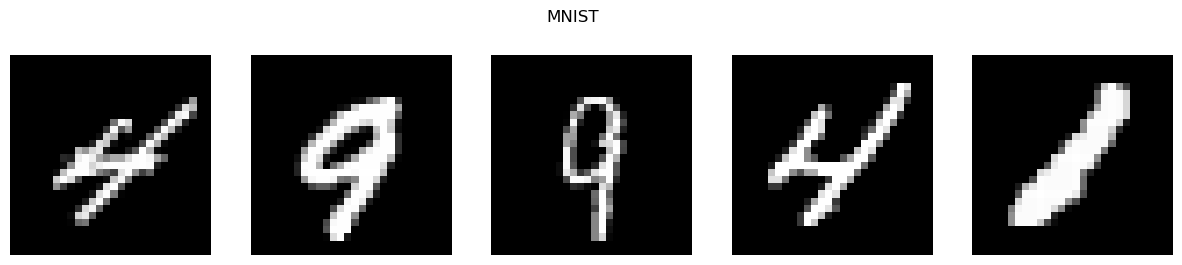

SVHN


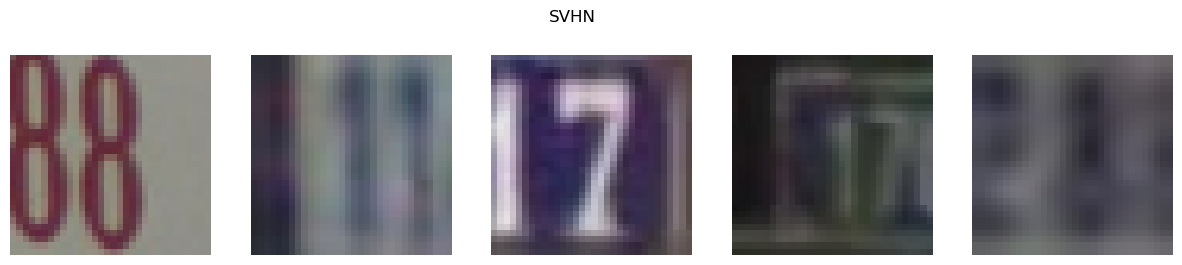

In [7]:
# computing the fft for probability of dropping from 0 to 99% 
def show_images(dataloader, title):
    print(dataloader)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    iterator = iter(dataloader)
    for i in range(5):
        images, labels = next(iterator)
        ax = axes[i]
        img = images[0].numpy().transpose((1, 2, 0)) if images[0].shape[0] == 3 else images[0].numpy().squeeze()
        ax.imshow(img, cmap='gray' if images[0].shape[0] == 1 else None)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Show 5 random images for each dataloader
for dataset_name, dataloader in dataloaders.items():
    print(dataset_name)
    show_images(dataloader, dataset_name)

In [57]:
# create mask given a kernel size, image size and probability 
def create_mask(image_res,kernel_size,proba,show=False):
    assert kernel_size<=image_res
    ratio = int(np.ceil(image_res/kernel_size))
    nb_events = int(ratio * ratio)
    random_events = round(proba*nb_events)*[0] + round((1-proba)*nb_events)*[1]
    random.shuffle(random_events)
    mask = np.reshape(random_events,[int(ratio),int(ratio)])
    mask = np.kron(mask, np.ones((kernel_size,kernel_size)))

    if show:
        plt.imshow(mask,cmap="gray")
        plt.show()
    return mask

def select_pixels(image_res,kernel_size,proba,show=False):
    assert kernel_size<=image_res
    ratio = int(np.ceil(image_res/kernel_size))
    nb_events = int(ratio * ratio)
    random_events = round(proba*nb_events)*[0] + round((1-proba)*nb_events)*[1]
    random.shuffle(random_events)
    mask = np.reshape(random_events,[int(ratio),int(ratio)])
    mask = np.kron(mask, np.ones((kernel_size,kernel_size)))
    mask = (mask-1)*(-1)
    return mask


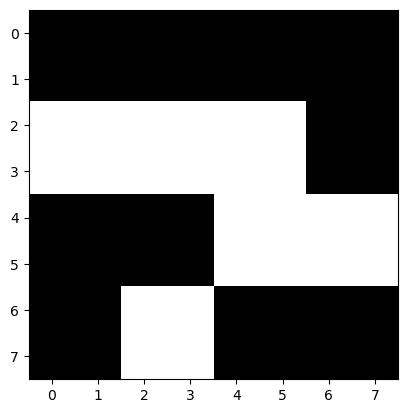

In [19]:
_=create_mask(8,2,0.6,show=True)

FashionMNIST


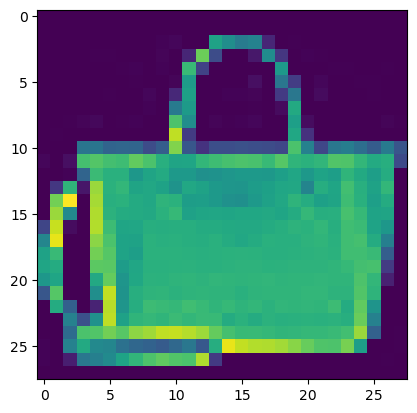

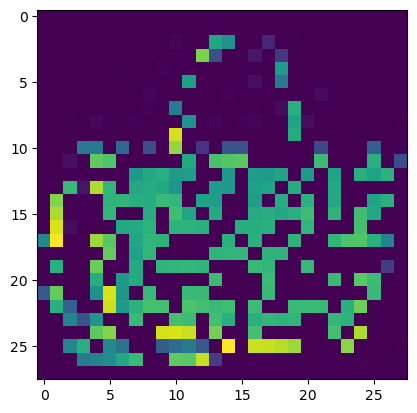

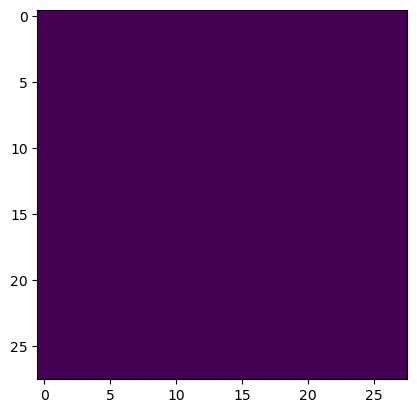

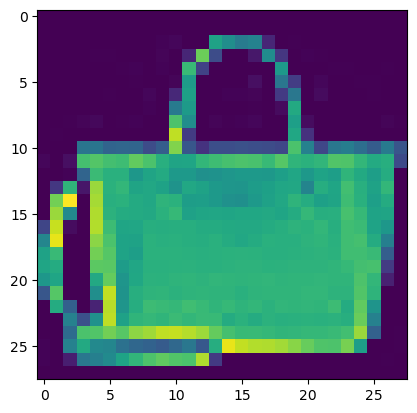

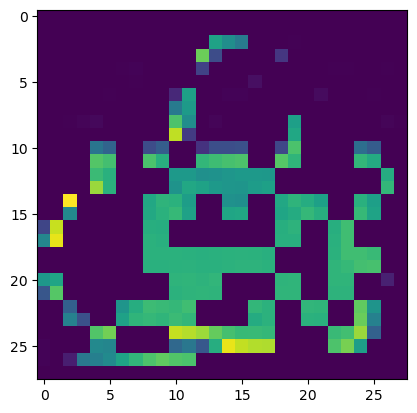

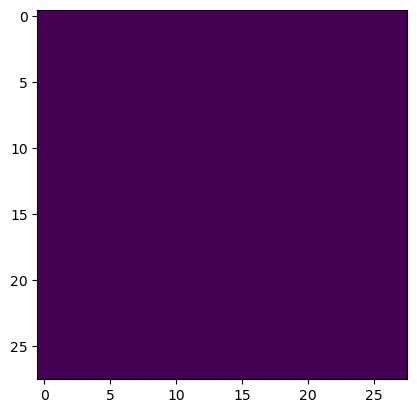

CIFAR10


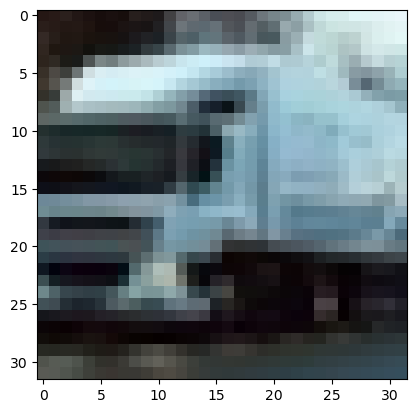

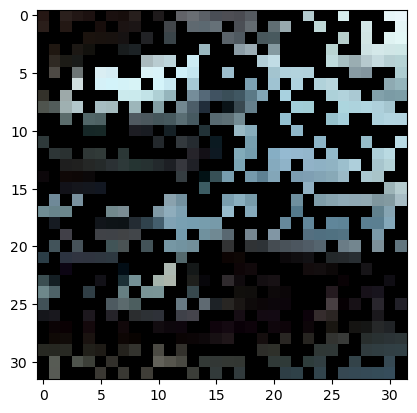

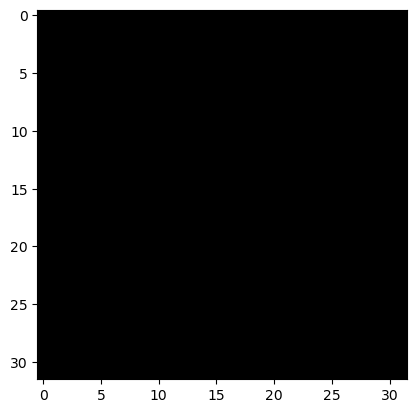

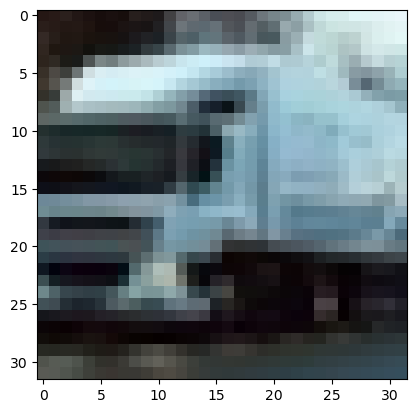

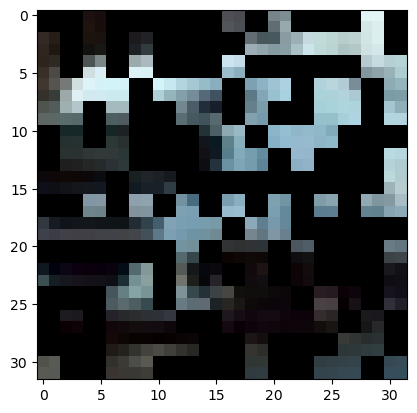

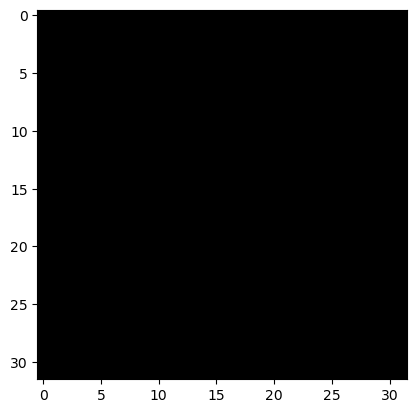

CIFAR100


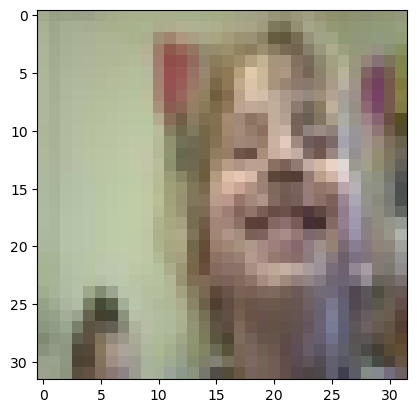

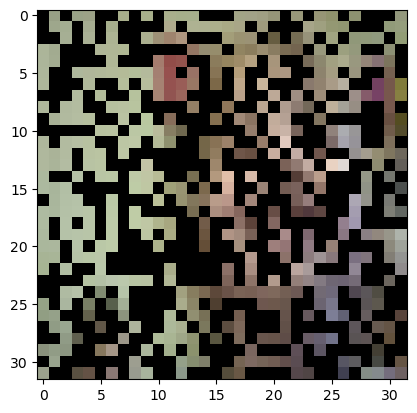

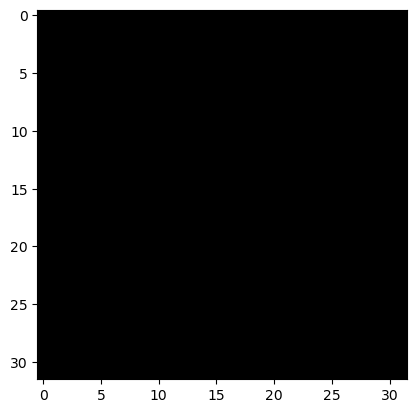

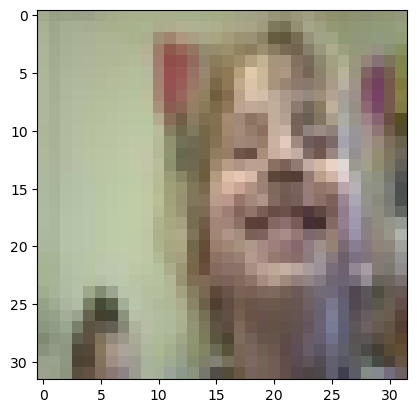

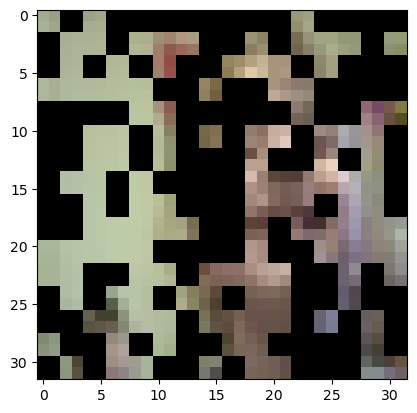

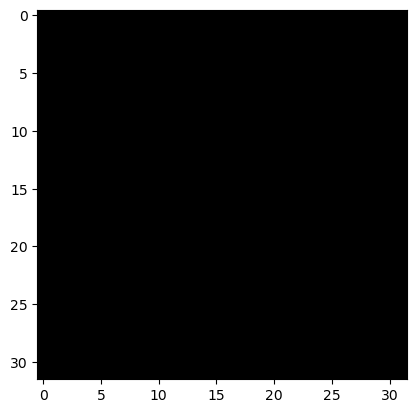

MNIST


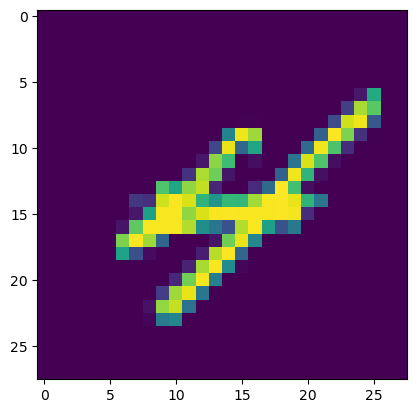

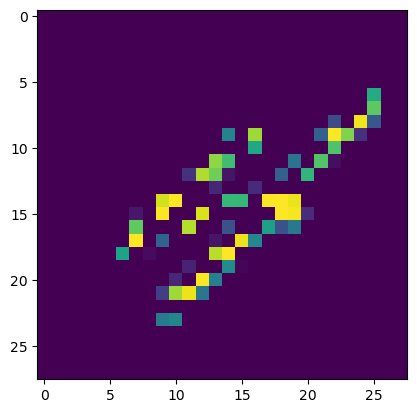

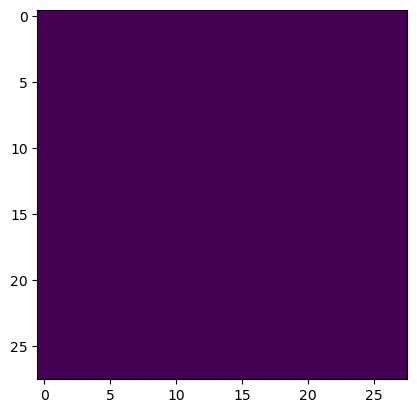

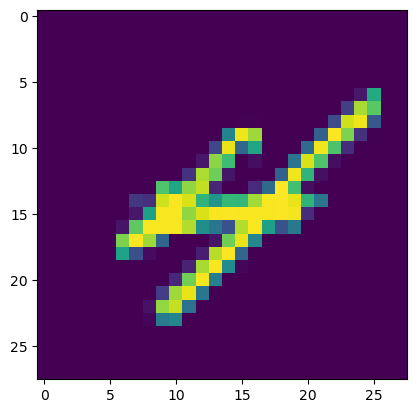

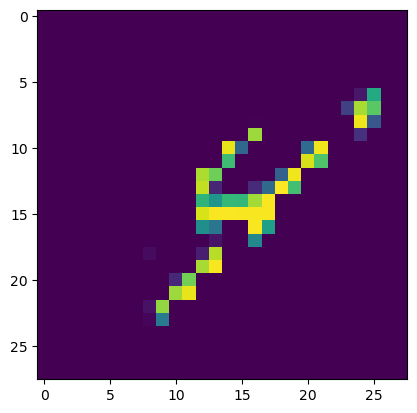

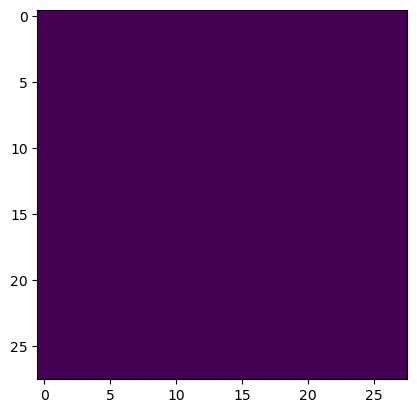

SVHN


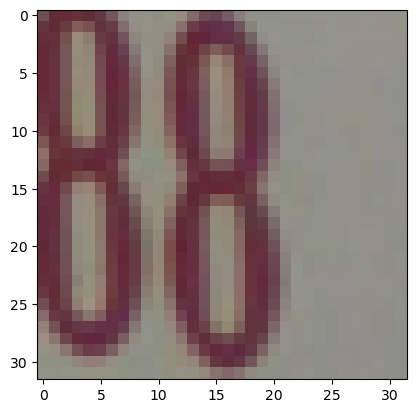

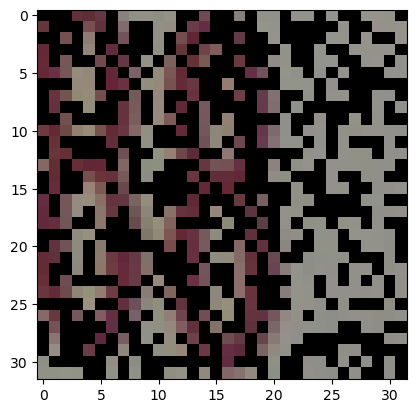

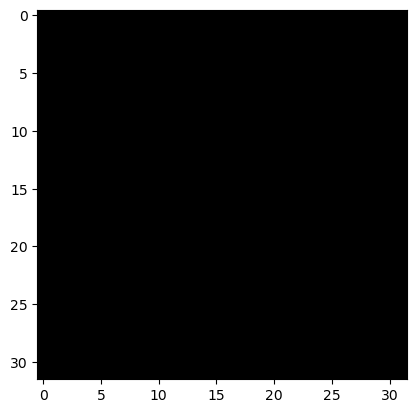

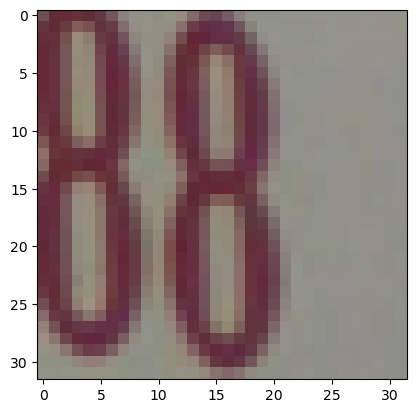

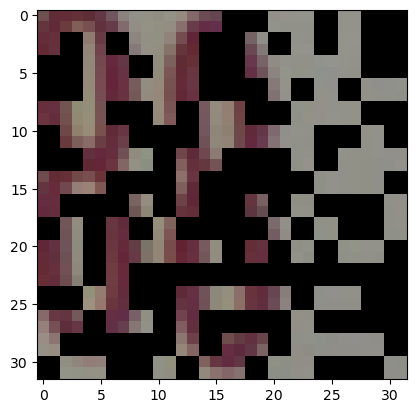

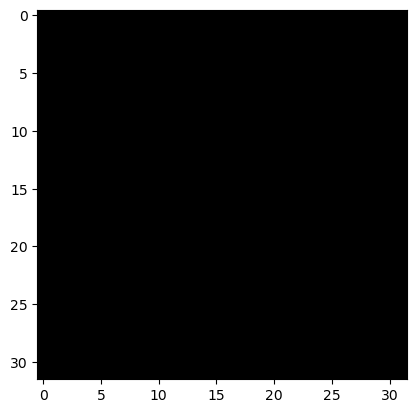

In [13]:
# for various masking size and probability, compute the fft for each of the 100 images and compute the mean and std of the 0 and 90 planes 
kernel_size = [1,2]
probability = [0,0.5,1.0]
planes = [0,90]

fft_computation = {}
fft_computation_mean = {}
fft_computation_std = {}

# initialize results variable
for dataset in list(dataloaders.keys()):
    fft_computation[dataset]={}
    fft_computation_mean[dataset]={}
    fft_computation_std[dataset]={}
    for k in kernel_size:
        fft_computation[dataset][k] = {}
        fft_computation_mean[dataset][k] = {}
        fft_computation_std[dataset][k] = {}

        for pb in probability:
            fft_computation[dataset][k][pb] = {}
            fft_computation_mean[dataset][k][pb] = {}
            fft_computation_std[dataset][k][pb] = {}

            for p in planes:
                fft_computation[dataset][k][pb][p] = []
                fft_computation_mean[dataset][k][pb][p] = []
                fft_computation_std[dataset][k][pb][p] = []

for dataset in list(dataloaders.keys()):
    print(dataset)
    data = dataloaders[dataset]
    for k in kernel_size:
        for pb in probability:
            img_tmp, _  = next(iter(data))
            image_res = img_tmp.shape[-1]
            for index, (img, _) in enumerate(data):
                # if index%99==0:print(index,"/total",)
                mask = torch.tensor(create_mask(image_res,k,pb))
                # print("mask",mask.shape,image_res)
                mask=mask.unsqueeze(0).repeat(img_tmp.shape[1],1,1)
                # print(mask.shape,img)
                img[0] = mask*img[0]
                if index==0:
                    if img.shape[1]==1:
                        plt.imshow(img[0,0,:,:])
                    else:
                        plt.imshow(np.swapaxes(np.swapaxes(img[0,:,:,:],0,2),0,1))
                    plt.show()
                np_img = torch2np_image(img)[0]
                if np_img.shape[-1]==3:
                    gray_np_img = rgb2gray(np_img)
                else: gray_np_img=np_img[:,:,0]
                plane_0, _, plane_90 = fft_planes(gray_np_img)
                # converting to grayscale (average of channels)
                fft_computation[dataset][k][pb][0].append(plane_0)
                fft_computation[dataset][k][pb][90].append(plane_90)


# print(fft_computation)
                    

    


In [29]:
# averaging 
for dataset in list(dataloaders.keys()):
    print(dataset)
    for k in kernel_size:
        for pb in probability:
            for p in planes:
                fft_computation_mean[dataset][k][pb][p] = np.mean(np.array(fft_computation[dataset][k][pb][p]),axis=0)
                fft_computation_std[dataset][k][pb][p] = np.std(np.array(fft_computation[dataset][k][pb][p]),axis=0)


FashionMNIST
CIFAR10
CIFAR100
MNIST
SVHN


In [85]:
# do we need something better than random masking ? 

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='/local/home/abizeul/data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='/local/home/abizeul/data', train=False, download=True, transform=transform)

# Subsample only cats (label 3) and dogs (label 5)
targets = np.array(train_set.targets)
cat_dog_indices = np.where((targets == 3) | (targets == 5))[0]
subset_train_set = Subset(train_set, cat_dog_indices)

targets = np.array(test_set.targets)
cat_dog_indices = np.where((targets == 3) | (targets == 5))[0]
subset_test_set = Subset(test_set, cat_dog_indices)

# Map cat label (3) to 0 and dog label (5) to 1
def target_transform(target):
    return 0 if target == 3 else 1

# print(typw(targets[cat_dog_indices][0])
# print(np.array([target_transform(target) for target in targets[cat_dog_indices]]).shape)
# subset_train_set.dataset.targets = np.array([target_transform(target) for target in targets[cat_dog_indices]])

# class RandomPixelSampling:
#     def __init__(self, percentage):
#         self.percentage = percentage

#     def __call__(self, sample):
#         # Flatten the image to 1D tensor
#         sample = sample.view(-1)
#         num_pixels = sample.size(0)
#         num_samples = int(num_pixels * self.percentage)
#         # Randomly sample x% of the pixels
#         indices = torch.randperm(num_pixels)[:num_samples]
#         return sample[indices]

class RandomPixelSampling:
    def __init__(self, kernel_size, percentage):
        self.percentage = percentage
        self.kernel_size = kernel_size

    def __call__(self, sample):
        # Flatten the image to 1D tensor
        mask = torch.tensor(select_pixels(sample.shape[1],self.kernel_size,self.percentage)).to(torch.bool)
        mask=mask.unsqueeze(0).repeat(sample.shape[0],1,1)
        mask = mask.view(-1)
        sample = sample.view(-1)
        sample = sample[mask]
        return sample

# Define the percentage of pixels to sample
percentages = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1]
kernel_size=1

# Update the transform to include RandomPixelSampling

for percentage in percentages:
    transform = transforms.Compose([
        transforms.Pad(16,0),
        transforms.ToTensor(),
        RandomPixelSampling(kernel_size,percentage)])

    subset_train_set.dataset.transform = transform
    subset_test_set.dataset.transform = transform

    train_loader = DataLoader(subset_train_set, batch_size=64, shuffle=True, drop_last=True)
    test_loader = DataLoader(subset_test_set, batch_size=64, shuffle=True, drop_last=True)

    class LinearBinaryClassifier(nn.Module):
        def __init__(self, input_dim):
            super(LinearBinaryClassifier, self).__init__()
            self.fc1 = nn.Linear(input_dim, 1000)
            self.fc2 = nn.Linear(1000, 500)
            self.fc3 = nn.Linear(500, 1)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            return torch.sigmoid(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x))))))

    # Initialize the model
    # Assuming the images are 32x32, hence 32*32*3 = 3072 pixels, and we're sampling 50% of them
    input_dim = int(round(64 * 64 * percentage)* 3)
    model = LinearBinaryClassifier(input_dim).to("cuda")

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 100
    overfits = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        score_train = 0 
        for inputs, labels in train_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the inputs
            labels = (labels==5).float().view(-1, 1)  # Reshape labels to match output

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs.to("cuda"))
            loss = criterion(outputs, labels.to("cuda"))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            predictions = (1*(outputs>0.5)).detach().cpu()
            score_train += sum(predictions==labels)

        score = 0
        for inputs,labels in test_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the inputs
            labels = (labels==5).float().view(-1, 1)  # Reshape labels to match output
            outputs = model(inputs.to("cuda"))
            predictions = (1*(outputs>0.5)).detach().cpu()
            score += sum(predictions==labels)

        train_acc, test_acc = round((score_train/(len(train_loader)*64)).item(),3), round((score/(len(test_loader)*64)).item(),3)
        overfits.append(train_acc-test_acc)
        if (epoch+1)%5==0: print(f'Epoch {epoch + 1}, Loss: {round((running_loss / len(train_loader)),3)}, Accuracy train: {train_acc}, Accuracy test: {test_acc}')
        if epoch>10: 
            if overfits[-1]>0.05:
                break
    print(f'Finished Training {percentage} in {epoch} epochs - Accuracy train: {train_acc}, Accuracy test: {test_acc}')

    # supervised baselines with varying number of pixels ( varying number of epochs - takes longer to train)
    # 100%: 65% - 58% |drops to 59% - 59% when padding borders to 64x64 resolution and taking same NUMBER of pixels
    # 90%: 65% - 60% | 59% - 60%
    # 80%: 64% - 60% | 59% - 59%
    # 70%: 64% - 58% | 58% - 59%
    # 60%: 64% - 61% | 58% - 58%
    # 50%: 63% - 60% | 58% - 59%
    # 40%: 63% - 61% | 58% - 59%
    # 30%: 62% - 60% | 58% - 58%
    # 20%: 61% - 61% | 57% - 58%
    # 10%: 60% - 60%


Files already downloaded and verified
Files already downloaded and verified
Epoch 5, Loss: 0.684, Accuracy train: 0.556, Accuracy test: 0.556
Epoch 10, Loss: 0.679, Accuracy train: 0.563, Accuracy test: 0.552
Epoch 15, Loss: 0.676, Accuracy train: 0.566, Accuracy test: 0.556
Epoch 20, Loss: 0.676, Accuracy train: 0.57, Accuracy test: 0.564
Epoch 25, Loss: 0.675, Accuracy train: 0.574, Accuracy test: 0.565
Epoch 30, Loss: 0.675, Accuracy train: 0.572, Accuracy test: 0.579
Epoch 35, Loss: 0.672, Accuracy train: 0.574, Accuracy test: 0.57
Epoch 40, Loss: 0.671, Accuracy train: 0.578, Accuracy test: 0.573
Epoch 45, Loss: 0.671, Accuracy train: 0.584, Accuracy test: 0.575
Epoch 50, Loss: 0.67, Accuracy train: 0.582, Accuracy test: 0.567
Epoch 55, Loss: 0.669, Accuracy train: 0.584, Accuracy test: 0.589
Epoch 60, Loss: 0.669, Accuracy train: 0.579, Accuracy test: 0.588
Epoch 65, Loss: 0.666, Accuracy train: 0.587, Accuracy test: 0.584
Epoch 70, Loss: 0.668, Accuracy train: 0.583, Accuracy te

In [70]:
del transforms

In [ ]:
# Load CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Subsample only cats (label 3) and dogs (label 5) for the test set
test_targets = np.array(test_set.targets)
test_cat_dog_indices = np.where((test_targets == 3) | (test_targets == 5))[0]
subset_test_set = Subset(test_set, test_cat_dog_indices)

# Map cat label (3) to 0 and dog label (5) to 1 for the test set
subset_test_set.dataset.targets = [target_transform(target) for target in test_targets[test_cat_dog_indices]]

# Update the transform for the test set
subset_test_set.dataset.transform = transform

# Create DataLoaders
train_loader = DataLoader(subset_train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(subset_test_set, batch_size=64, shuffle=False)


In [ ]:
# Function to evaluate the model
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the inputs
            labels = labels.float().view(-1, 1)  # Reshape labels to match output
            
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary output
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
